## 3. Topic Modelling

In this notebook, I will use LDA (Latent Dirichlet Allocation), a generative probabilistic model,  to discover the topic distribution in each document (review/comment) and the word distribution in each topic.

In [89]:
import numpy as np
import plotly
import plotly.graph_objects as go
import plotly.offline as py
import matplotlib.pyplot as plt
from wordcloud import WordCloud

### 3.1 Pre-processing

Continuing our work from the previous preprocessing notebook, here we need to convert the token lists to sentences (string) which is used as documents within the corpus.

In [32]:
import pandas as pd

df = pd.read_pickle("cleaned_review.pkl")
display(df.head())
df.shape

,name,rating,comment,tokenized_comment,word_count
0,Nottingham Trent University,4,Staff is kind and supportive; giving good advi...,"[staff, kind, supportive, giving, advice, deta...",334
1,University of Suffolk,5,There is nothing as great as hoping and seeing...,"[nothing, hoping, seeing, dream, come, fruitio...",333
2,Queen Mary University of London,4,Facilities:\nQueen Mary University of London s...,"[facility, queen, mary, london, stand, forefro...",332
3,University of Portsmouth,5,I have absolutely loved my experience with UoP...,"[absolutely, loved, experience, uop, would, hi...",331
4,University of Gloucestershire,5,Really it is giving a great learning opportuni...,"[giving, learning, opportunity, career, opport...",327


(5691, 5)

In [33]:
# Initialise a blank list
sentences = []

for comment in df["tokenized_comment"]:
    sentence = " ". join(comment)
    sentences.append(sentence)

# Make sure the number of sentences is the same with the df's number of rows
print(len(sentences))

# Print out the first 5 sentences
sentences[:5]

["staff kind supportive giving advice detailed feedback encouraging discussion safe space psychology multiple facility e.g. experimental lab vr etc use project bsc msc library open 24h- use printers/pcs rent laptop read/loan book study area suit e.g. silent area book academic support session group study rooms/tables many society sport gym study city campus live near it- easy access shop night life entertainment employability team amazing helped placement bsc degree listened concern lack resource mental health job interviews- went department gathered different psychology related question might come job interview staff expected answer employability team sends advertisement multiple volunteering/ job opportunity put workshop help develop employability skill hold job fair support for/can accommodate mental/physical health issue various disabilities- creating access statement and/or learning agreement e.g. extra exam time 1-1 presentation improvement increasing understanding/being considera

In [34]:
# Add a new column of "sentences" to the df
df["sentence"] = sentences

df.head()

,name,rating,comment,tokenized_comment,word_count,sentence
0,Nottingham Trent University,4,Staff is kind and supportive; giving good advi...,"[staff, kind, supportive, giving, advice, deta...",334,staff kind supportive giving advice detailed f...
1,University of Suffolk,5,There is nothing as great as hoping and seeing...,"[nothing, hoping, seeing, dream, come, fruitio...",333,nothing hoping seeing dream come fruition hope...
2,Queen Mary University of London,4,Facilities:\nQueen Mary University of London s...,"[facility, queen, mary, london, stand, forefro...",332,facility queen mary london stand forefront aca...
3,University of Portsmouth,5,I have absolutely loved my experience with UoP...,"[absolutely, loved, experience, uop, would, hi...",331,absolutely loved experience uop would highly r...
4,University of Gloucestershire,5,Really it is giving a great learning opportuni...,"[giving, learning, opportunity, career, opport...",327,giving learning opportunity career opportunity...


### 3.2 Word Representation

Next, we need to choose a method to represent each document in a vector. Here I have chosen TfidVectorizer, a tool provided by scikit-learn that transforms a collection of raw documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialise the vectorizer
tf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, stop_words='english')
# max_df refers to ignore terms that appears in more than 85% across the documents
# min_df refers to only include terms that appear at least 2 documents of the corpus
# stop_words helps remove common stop words in English

# # Fit and transform the corpus into TF-IDF matrix
tf = tf_vectorizer.fit_transform(df["sentence"])

In [76]:
tf

<5691x6173 sparse matrix of type '<class 'numpy.float64'>'
	with 189548 stored elements in Compressed Sparse Row format>

In [77]:
feature_names = tf_vectorizer.get_feature_names_out()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [119]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, max_iter=10,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 42,
                                doc_topic_prior=0.5,     # Assume documents are represented by fewer topics
                                topic_word_prior=0.01,   # Assume topics are represented by fewer words
                                )

In [120]:
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.5, learning_method='online',
                          learning_offset=50.0, n_components=5, random_state=42,
                          topic_word_prior=0.01)

In [121]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [133]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:best course staff feel time uni like help thing people lecturer amazing friendly helpful city life love library international lecture new school work worst union far location think different year class nice tutor building better studying way event accommodation available

Topic #1:research diverse offer resource education program faculty quality skill provides practical teaching range professional activity overall field art improvement supportive high providing diversity institution industry modern strong personal various academic social vibrant knowledge positive excellent including provide development life equipped

Topic #2:study experience aspect environment support community facility learning campus ofcourse academic dirty washroom china battle render cordial citizen isolate progressing pricy yellow quantity hurry monitoring cleared uon musician ux belongs tablet distribution iwould virus icing stride wacom hated blink drill

Topic #3:support place

In [134]:
topic1 = lda.components_[0]
topic2 = lda.components_[1]
topic3 = lda.components_[2]
topic4 = lda.components_[3]

In [135]:
topic1.shape

(6173,)

In [136]:
topic1_words = [tf_feature_names[i] for i in topic1.argsort()[:-50 - 1 :-1]]
topic2_words = [tf_feature_names[i] for i in topic2.argsort()[:-50 - 1 :-1]]
topic3_words = [tf_feature_names[i] for i in topic3.argsort()[:-50 - 1 :-1]]
topic4_words = [tf_feature_names[i] for i in topic4.argsort()[:-50 - 1 :-1]]

In [141]:
# Generating the wordcloud with the values under the category dataframe
wordcloud1 = WordCloud(
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic1_words))

wordcloud2 = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic2_words))

wordcloud3 = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic3_words))

wordcloud4 = WordCloud(
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic4_words))


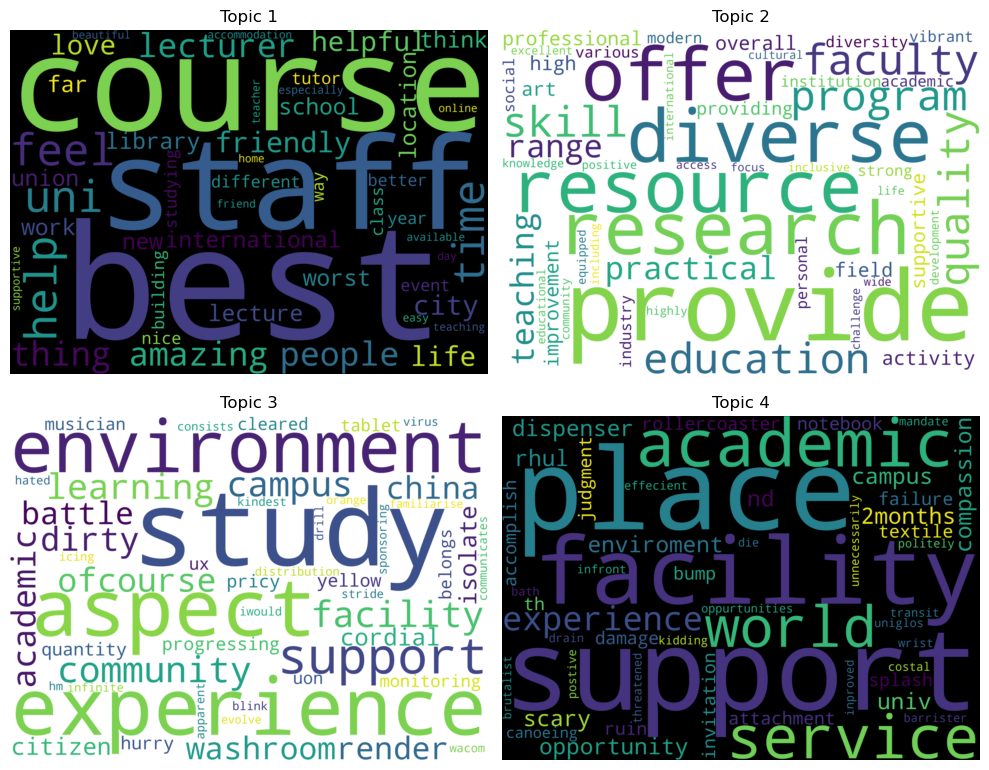

In [142]:
# Create a figure to display the word clouds
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each word cloud in a subplot
axes[0, 0].imshow(wordcloud1, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Topic 1')

axes[0, 1].imshow(wordcloud2, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title('Topic 2')

axes[1, 0].imshow(wordcloud3, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title('Topic 3')

axes[1, 1].imshow(wordcloud4, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title('Topic 4')

# Adjust layout
plt.tight_layout()
plt.show()

From the above wordclouds, we can see that:
**Topic 1** is associated with "staff, lecturer, people, friendly, helpful"
**Topic 2** is associated with ""